DQN GRID

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from gym import spaces


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
a = [[1,2,3,4],1,1,[5,6,7,8]]
b = ["s","a","r","s'"]

dict(zip(b,a))

{'s': [1, 2, 3, 4], 'a': 1, 'r': 1, "s'": [5, 6, 7, 8]}

In [ ]:
from itertools import cycle
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, transition: list):
        """Save a transition"""
        self.memory.append(transition)

    def sample(self, batch_size):
        sample_list = random.sample(self.memory, batch_size)
        dict_keys = ["state","action","reward","next_state","done"] # Convert to dictionary for ease of use and understanding
        
        sample_dicts = list(map(lambda sample: dict(zip(dict_keys,sample)), sample_list))
        #sample_dict = [zip(sample, dict_keys) for sample in sample list]
        
        return sample_dicts

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):
    
    def __init__(self,state_space_len=None,
                 action_space_len=None):
        super(DQN, self).__init__()

        assert state_space_len is not None
        assert action_space_len is not None

        self.fc1 = nn.Linear(state_space_len, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_space_len)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return self.fc3(x)

    def sample_action(self, obs, epsilon):
        if random.random() < epsilon:
            return random.randint(0,3)
        else:
            return self.forward(obs).argmax().item()
    

In [ ]:
class GridEnvironment(gym.Env):
    
    def __init__(self, environment_type, max_timesteps):

        self.environment_type = environment_type
        self.environment_width = 4
        self.environment_height = 4

        self.observation_space = spaces.Discrete(self.environment_width * self.environment_height)
        self.action_space = spaces.Discrete(4)

        self.number_of_agents = 1
        self.agent_pos = np.asarray([0, 0])
        self.goal_pos = np.asarray([3, 3])

        self.candy_pos = np.asarray([0, 3])
        self.diamond_pos = np.asarray([1, 3])
        self.coin_pos = np.asarray([2, 1])

        self.gold_collected = False
        self.candy_collected = False
        self.diamond_collected = False
        self.coin_collected = False


        self.state = np.zeros((4, 4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.candy_pos)] = 0.4
        self.state[tuple(self.diamond_pos)] = 0.3
        self.state[tuple(self.coin_pos)] = 0.2
        
        self.timestep = 0
        self.max_timesteps = max_timesteps
        self.epsilon = 0.9


        
    def reset(self):
        self.timestep = 0
        self.agent_pos = np.asarray([0, 0])
        self.goal_pos = np.asarray([3, 3])
        self.state = np.zeros((4, 4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        observation = self.state.flatten()
        self.gold_collected = False
        self.candy_collected = False
        self.diamond_collected = False
        self.coin_collected = False
        
        return observation
    
    def step(self, action: int):
        rand_num = np.random.random()

        # if self.environment_type != "deterministic":
        #   if np.random.random() > self.epsilon: # exploitation
        #       action = random.choice([0,1,2,3])
         
        if action == 0:
            self.agent_pos[1] += 1 # right
        if action == 1:
          self.agent_pos[0] += 1 # down
        if action == 2:
          self.agent_pos[1] -= 1 # left
        if action == 3:
          self.agent_pos[0] -= 1 # up
        

        self.agent_pos = list(np.clip(self.agent_pos, 0, 3))
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        
        self.state[tuple(self.candy_pos)] = 0.4
        self.state[tuple(self.diamond_pos)] = 0.3
        self.state[tuple(self.coin_pos)] = 0.2


        observation = self.state.flatten()
        
        reward = -1
        terminal_state_reached = False
        if (self.agent_pos == self.goal_pos).all():
            terminal_state_reached = True
            if not self.gold_collected:
              reward = 10
              self.gold_collected = True

        # if (self.agent_pos == self.diamond_pos).all():
        #   if not self.diamond_collected:
        #       reward = 5
        #       self.diamond_collected = True
            
        # if (self.agent_pos == self.candy_pos).all():
        #   if not self.candy_collected:
        #       reward = 3
        #       self.candy_collected = True
            
        # if (self.agent_pos == self.coin_pos).all():
        #   if not self.coin_collected:
        #       reward = 1
        #       self.coin_collected = True
            
        self.timestep += 1
        done = True if (self.timestep > self.max_timesteps) or terminal_state_reached else False
        
        
        info = {}
        action_new = action
        
        return observation, reward, done,terminal_state_reached, action_new


    def render(self):
        plt.figure()
        plt.imshow(self.state)


In [ ]:
from collections import defaultdict
def train_step():
    assert len(memory)> BATCH_SIZE, "Check code! Memory length should be greater than Batch size, only then this function is called"

    batch = memory.sample(BATCH_SIZE)
    #print(batch)
    dd = defaultdict(list)

    # Merge list of dicts into one single dict
    for d in batch:
      for key, value in d.items():
          dd[key].append(value)

    batch = dd

    #print(batch)
    
    state_batch = torch.FloatTensor(batch.get("state")).to(device)
    action_batch = torch.LongTensor(batch.get("action")).unsqueeze(1).to(device)
    reward_batch = torch.FloatTensor(batch.get("reward")).unsqueeze(1).to(device)
    next_state_batch = torch.FloatTensor(batch.get("next_state")).to(device)
    done_batch = torch.FloatTensor(batch.get("done")).unsqueeze(1).to(device)


    #Forward prop target network and calculate target(yi)
    #print(next_state_batch.shape)
    #print(primary_net(next_state_batch))
    Q_primary_max_action_batch = primary_net(next_state_batch).argmax(dim=1).unsqueeze(1).detach()
    
    Q_optimal = reward_batch + GAMMA *  target_net(next_state_batch).gather(1, Q_primary_max_action_batch).detach() * done_batch

    #Q_target_max = target_net(next_state_batch).max(1)[0].unsqueeze(1).detach()

    #target_batch = reward_batch + GAMMA * Q_target_max * done_batch
    #print(state_batch.shape)
    #print(action_batch.shape)
    Q_primary = primary_net(state_batch).gather(1, action_batch)
    
    #Calculate Loss
    criterion = nn.MSELoss() #HuberLoss()#MSELoss() #Check Loss MSE
    loss = criterion(Q_optimal, Q_primary)

    # Backprop gradients
    optimizer.zero_grad()
    loss.backward()
    for param in primary_net.parameters():
        param.grad.data.clamp_(-1, 1)

    optimizer.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Complete


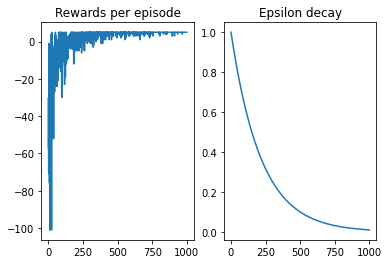

In [ ]:
from gym.spaces.discrete import Discrete # Scale reward [-1,1]
BATCH_SIZE = 32 #200 # around 32 for cartpole
GAMMA = 0.9 #0.999
EPS_START = 1
EPS_END = 0.01

epsilon = EPS_START
learning_rate = 1e-3


TARGET_UPDATE = 10
max_step = 100 #2000
num_episodes = 1000
rewards_per_episode = []

decay_factor = math.pow((EPS_END / EPS_START),(1/num_episodes))
epsilon_per_episode = []
epsilon_per_episode.append(epsilon)

env = GridEnvironment("deterministic",max_timesteps=max_step)

memory = ReplayMemory(5000) # <10000
Discrete
n_actions = env.action_space.n
#print(env.observation_space)
primary_net = DQN(env.observation_space.n,env.action_space.n).to(device)
target_net = DQN(env.observation_space.n,env.action_space.n).to(device)
target_net.load_state_dict(primary_net.state_dict())
target_net.eval()

optimizer = optim.Adam(primary_net.parameters(),lr=learning_rate)


steps_done = 0


for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    
    for t in count():
        # Select and perform an action    
        action = primary_net.sample_action(torch.from_numpy(state).float().to(device),epsilon) # check
        # observation, reward, done,terminal_state_reached, action_new
        next_state, reward, done, terminal_state_reached,_ = env.step(action)
        #print(terminal_state_reached)
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        memory.push([state, action,reward,next_state,not terminal_state_reached])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          train_step()
        if done:
            break
    
    epsilon = epsilon * decay_factor
    epsilon_per_episode.append(epsilon)
    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(primary_net.state_dict())

    rewards_per_episode.append(curr_episode_reward)
    # if (i_episode+1)%100==0:
      # plt.title("Reward per episode")
      # plt.xlabel('episodes')
      # plt.ylabel('reward')
      # plt.plot(rewards_per_episode, color="blue")
      # plt.show()

print('Complete')
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Rewards per episode')
ax[0].plot(rewards_per_episode)

ax[1].set_title('Epsilon decay')
ax[1].plot(epsilon_per_episode)

plt.savefig("Assignment2_GridWorld.png",dpi=1200)
#env.render()
# env.close()
# plt.ioff()
# plt.show()

Complete


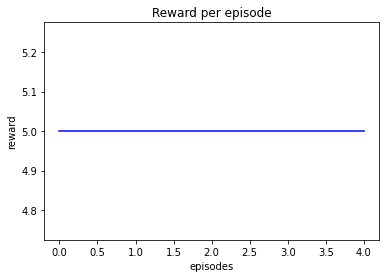

<Figure size 432x288 with 0 Axes>

In [ ]:
# Evaluation for 5 episodes
eval_epsiodes = 5
rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    epsilon = 0
    
    for t in count():
        # Select and perform an action    
        action = primary_net.sample_action(torch.from_numpy(state).float().to(device),epsilon) # check
        # observation, reward, done,terminal_state_reached, action_new
        next_state, reward, done, terminal_state_reached,_ = env.step(action)
        #print(terminal_state_reached)
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        #memory.push([state, action,reward,next_state,not terminal_state_reached])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        # if len(memory)>BATCH_SIZE:
        #   pass
          #train_step()
        if done:
            break
    
    # epsilon = epsilon * decay_factor
    # epsilon_per_episode.append(epsilon)
    
    # Update the target network, copying all weights and biases in DQN
    # if i_episode % TARGET_UPDATE == 0:
    #     target_net.load_state_dict(policy_net.state_dict())

    rewards_per_episode.append(curr_episode_reward)
    # if (i_episode+1)%100==0:
      # plt.title("Reward per episode")
      # plt.xlabel('episodes')
      # plt.ylabel('reward')
      # plt.plot(rewards_per_episode, color="blue")
      # plt.show()

print('Complete')
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(rewards_per_episode, color="blue")
plt.show()
plt.savefig("Gridworld_evaluation.png",dpi=1200)


# **CartPole**


In [ ]:
%matplotlib inline

In [ ]:
%%bash
pip3 install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v1')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


cuda


In [ ]:
a = [[1,2,3,4],1,1,[5,6,7,8]]
b = ["s","a","r","s'"]

dict(zip(b,a))

{'s': [1, 2, 3, 4], 'a': 1, 'r': 1, "s'": [5, 6, 7, 8]}

In [ ]:
from itertools import cycle
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, transition: list):
        """Save a transition"""
        self.memory.append(transition)

    def sample(self, batch_size):
        sample_list = random.sample(self.memory, batch_size)
        dict_keys = ["state","action","reward","next_state","done"] # Convert to dictionary for ease of use and understanding
        
        sample_dicts = list(map(lambda sample: dict(zip(dict_keys,sample)), sample_list))
        #sample_dict = [zip(sample, dict_keys) for sample in sample list]
        
        return sample_dicts

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):
    
    def __init__(self,state_space_len=None,
                 action_space_len=None):
        super(DQN, self).__init__()

        assert state_space_len is not None
        assert action_space_len is not None

        self.fc1 = nn.Linear(state_space_len, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_space_len)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return self.fc3(x)

    def sample_action(self, obs, epsilon):
        if random.random() < epsilon:
            return random.randint(0,1)
        else:
            return self.forward(obs).argmax().item()
    

In [ ]:
a = [{'a':1},{'b':2},{'c':1},{'d':2},{'b':3}]
from collections import defaultdict
dd = defaultdict(list)

for d in a: # you can list as many input dicts as you want here
    for key, value in d.items():
        dd[key].append(value)
    
print(dd)


defaultdict(<class 'list'>, {'a': [1], 'b': [2, 3], 'c': [1], 'd': [2]})


In [ ]:
from collections import defaultdict
def train_step():
    assert len(memory)> BATCH_SIZE, "Check code! Memory length should be greater than Batch size, only then this function is called"

    batch = memory.sample(BATCH_SIZE)
    #print(batch)
    dd = defaultdict(list)

    # Merge list of dicts into one single dict
    for d in batch:
      for key, value in d.items():
          dd[key].append(value)

    batch = dd

    #print(batch)
    
    state_batch = torch.FloatTensor(np.asarray(batch.get("state"))).to(device)
    action_batch = torch.LongTensor(np.asarray(batch.get("action"))).unsqueeze(1).to(device)
    reward_batch = torch.FloatTensor(np.asarray(batch.get("reward"))).unsqueeze(1).to(device)
    next_state_batch = torch.FloatTensor(np.asarray(batch.get("next_state"))).to(device)
    done_batch = torch.FloatTensor(np.asarray(batch.get("done"))).unsqueeze(1).to(device)


    #Forward prop target network and calculate target(yi)
    Q_target_max = target_net(next_state_batch).max(1)[0].unsqueeze(1).detach()
    target_batch = reward_batch + GAMMA * Q_target_max * done_batch
    #print(state_batch.shape)
    #print(action_batch.shape)
    Q_policy = policy_net(state_batch).gather(1, action_batch)
    
    #Calculate Loss
    criterion = nn.MSELoss()#HuberLoss()#MSELoss() #Check Loss MSE
    loss = criterion(target_batch,Q_policy)

    # Backprop gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

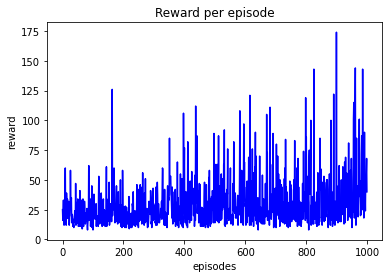

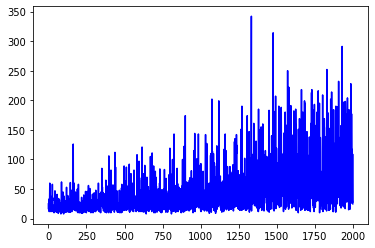

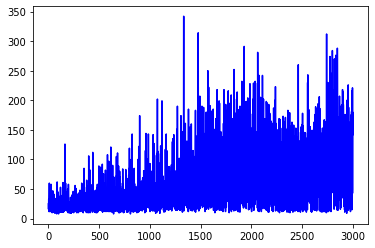

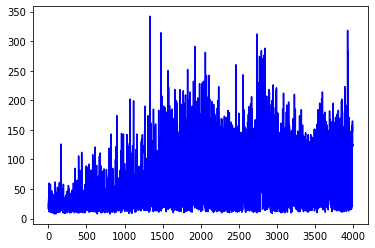

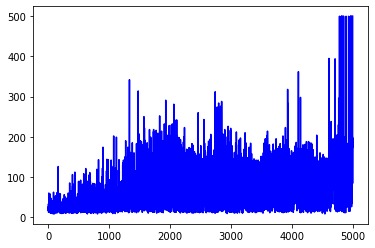

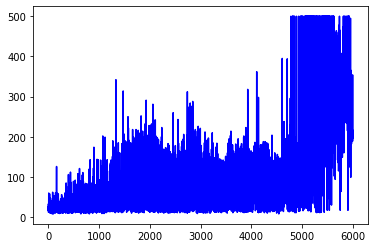

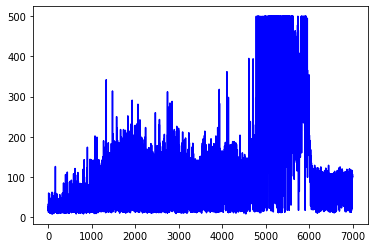

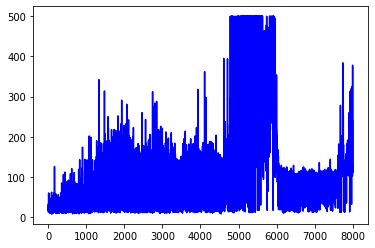

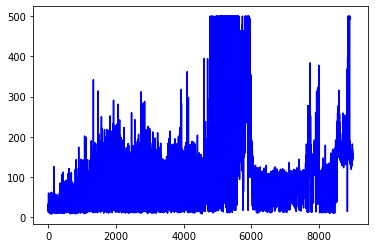

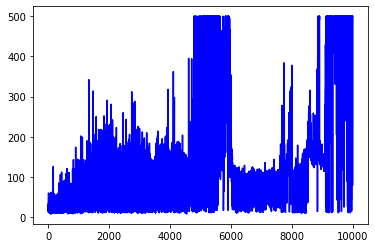

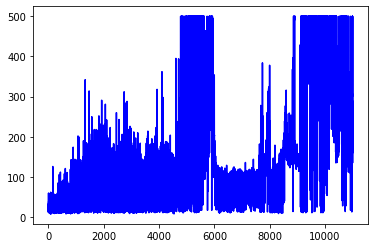

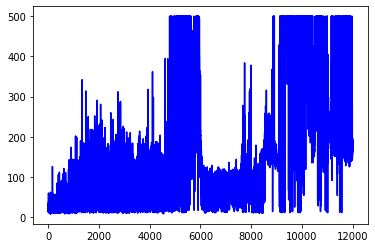

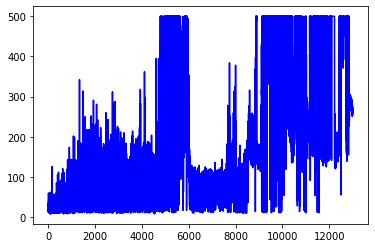

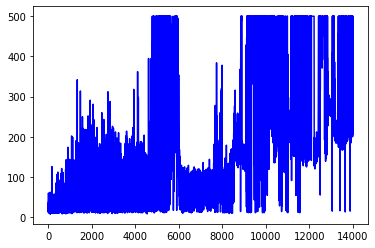

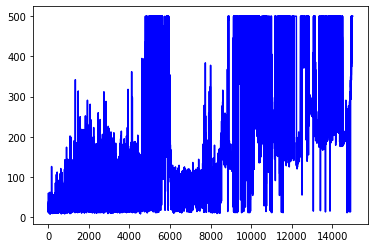

Complete


In [ ]:
BATCH_SIZE = 32 # 64around 32 for cartpole
GAMMA = 0.999
EPS_START = 1
EPS_END = 0.01 # check epsilon value

epsilon = EPS_START
learning_rate = 1e-4


TARGET_UPDATE = 69
max_step = 2000 # 1000
num_episodes = 15000
rewards_per_episode = []

decay_factor = math.pow((EPS_END / EPS_START),(1/num_episodes))
epsilon_per_episode = []
epsilon_per_episode.append(epsilon)


memory = ReplayMemory(10000) # <10000

n_actions = env.action_space.n

policy_net = DQN(env.observation_space.shape[0],env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0],env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(),lr=learning_rate)


steps_done = 0
loss_per_episode = []

#fig, ax = plt.subplots(1, 2)
#plt.clf()
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    episode_loss = 0
    t = 0
    for t in count():
        # Select and perform an action    
        action = policy_net.sample_action(torch.from_numpy(state).float().to(device),epsilon)
        
        next_state, reward, done, _ = env.step(action)
        curr_episode_reward += reward
        reward = np.clip(reward, -1, 1)

        #print(done)
        # Store the transition in memory
        memory.push([state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state
        

        # Perform one step of optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          loss = train_step()
          episode_loss+=loss
          
        if done:
            break
    
    loss_per_episode.append(episode_loss/t)
    epsilon = epsilon * decay_factor
    epsilon_per_episode.append(epsilon)

    


    # Every C steps update the target network with the policy network's weights/params
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    rewards_per_episode.append(curr_episode_reward)
    if (i_episode+1)%1000==0:
      
      # ax[0].set_title('Rewards per episode')
      # ax[0].plot(rewards_per_episode)

      # ax[1].set_title('Loss per episode')
      # ax[1].plot(loss_per_episode)

      
      plt.plot(rewards_per_episode, color="blue")
      plt.show()

      # plt.title("Reward per episode")
      # plt.xlabel('episodes')
      # plt.ylabel('reward')
      # plt.plot(rewards_per_episode, color="blue")
      #plt.show()

print('Complete')
#env.render()
# env.close()
# plt.ioff()
# plt.show()

Complete


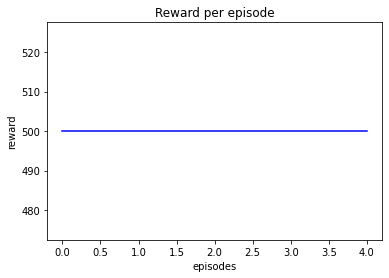

In [ ]:
# plt.title("Epsilon decay")
# # plt.xlabel('episodes')
# # plt.ylabel('reward')
# plt.plot(epsilon_per_episode, color="blue")# Evaluation for 5 episodes
eval_epsiodes = 5
eval_rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    epsilon = 0
    
    for t in range(1,2000):
        # Select and perform an action    
        action = policy_net.sample_action(torch.from_numpy(state).float().to(device),epsilon) # check
        # observation, reward, done,terminal_state_reached, action_new
        next_state, reward, done, _ = env.step(action)
        #print(terminal_state_reached)
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        #memory.push([state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          pass
          #train_step()
        if done:
            break
    
    # epsilon = epsilon * decay_factor
    # epsilon_per_episode.append(epsilon)
    
    # Update the target network, copying all weights and biases in DQN
    #if i_episode % TARGET_UPDATE == 0:
        #target_net.load_state_dict(policy_net.state_dict())

    eval_rewards_per_episode.append(curr_episode_reward)
    # if (i_episode+1)%100==0:
      # plt.title("Reward per episode")
      # plt.xlabel('episodes')
      # plt.ylabel('reward')
      # plt.plot(rewards_per_episode, color="blue")
      # plt.show()

print('Complete')

plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(eval_rewards_per_episode, color="blue")
plt.show()
#plt.savefig("CartPole_evaluation.png",dpi=1200)

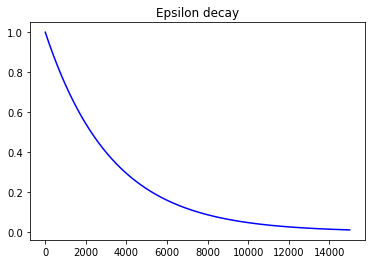

In [ ]:
plt.title("Epsilon decay")

plt.plot(epsilon_per_episode, color="blue")
plt.show()
#plt.savefig("Rewards_per_episode_Cartpole.png",dpi = 1200)

In [ ]:
epsilon_per_episode

# **Mountain Car**

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
%%bash
pip3 install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env3 = gym.make('MountainCar-v0')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [ ]:
from itertools import cycle
class ReplayMemory3(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, transition: list):
        """Save a transition"""
        self.memory.append(transition)

    def sample(self, batch_size):
        sample_list = random.sample(self.memory, batch_size)
        dict_keys = ["state","action","reward","next_state","done"] # Convert to dictionary for ease of use and understanding
        
        sample_dicts = list(map(lambda sample: dict(zip(dict_keys,sample)), sample_list))
        #sample_dict = [zip(sample, dict_keys) for sample in sample list]
        
        return sample_dicts

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN3(nn.Module):
    
    def __init__(self,state_space_len=None,
                 action_space_len=None):
        super(DQN3, self).__init__()

        assert state_space_len is not None
        assert action_space_len is not None

        self.fc1 = nn.Linear(state_space_len, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, action_space_len)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return self.fc3(x)


In [ ]:
from collections import defaultdict
def sample_action(l,state):
      if random.random() < epsilon:
          return random.randint(0,2)
      else:
          return np.argmax(l(torch.tensor(state,dtype=torch.float)).data.numpy())
def train_step():
    assert len(memory)> BATCH_SIZE, "Check code! Memory length should be greater than Batch size, only then this function is called"

    batch = memory.sample(BATCH_SIZE)
    #print(batch)
    dd = defaultdict(list)

    # Merge list of dicts into one single dict
    for d in batch:
      for key, value in d.items():
          dd[key].append(value)

    batch = dd

    #print(batch)
    
    state_batch = torch.FloatTensor(batch.get("state")).to(device)
    action_batch = torch.LongTensor(batch.get("action")).unsqueeze(1).to(device)
    reward_batch = torch.FloatTensor(batch.get("reward")).unsqueeze(1).to(device)
    next_state_batch = torch.FloatTensor(batch.get("next_state")).to(device)
    done_batch = torch.FloatTensor(batch.get("done")).unsqueeze(1).to(device)


    #Forward prop target network and calculate target(yi)
    Q_target_max = target_net(next_state_batch).detach().max(1)[0].unsqueeze(1)
    target_batch = reward_batch + GAMMA * Q_target_max * done_batch
    #print(state_batch.shape)
    #print(action_batch.shape)
    Q_policy = policy_net(state_batch).gather(1, action_batch)
    
    #Calculate Loss
    criterion = nn.MSELoss()#HuberLoss()#MSELoss() #Check Loss MSE
    loss = criterion(Q_policy, target_batch)

    # Backprop gradients
    optimizer.zero_grad()
    loss.backward()
    #for param in policy_net.parameters():
        #param.grad.data.clamp_(-1, 1)

    optimizer.step()

In [ ]:
a = [{'a':1},{'b':2},{'c':1},{'d':2},{'b':3}]
from collections import defaultdict
dd = defaultdict(list)

for d in a: # you can list as many input dicts as you want here
    for key, value in d.items():
        dd[key].append(value)
    
print(dd)


defaultdict(<class 'list'>, {'a': [1], 'b': [2, 3], 'c': [1], 'd': [2]})


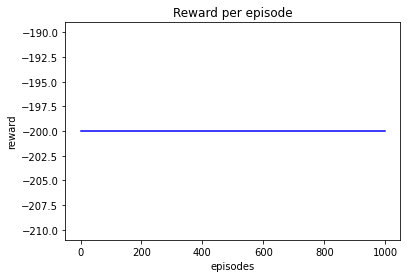

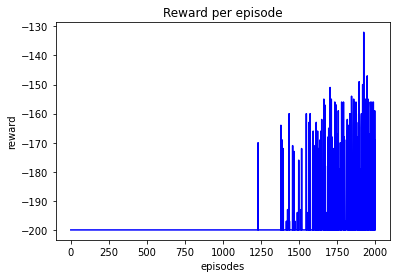

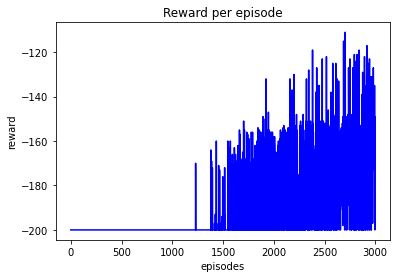

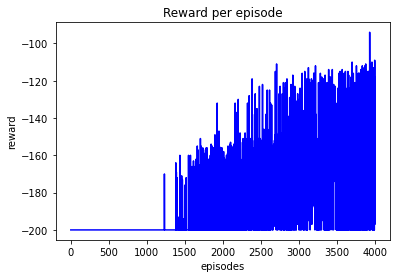

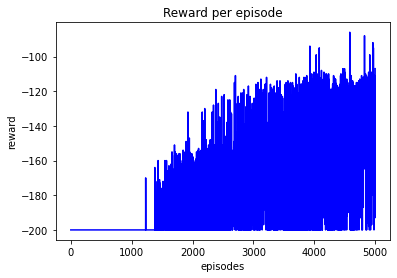

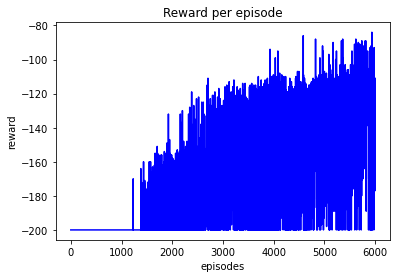

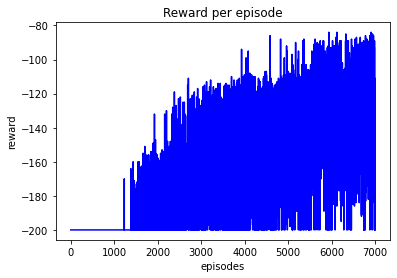

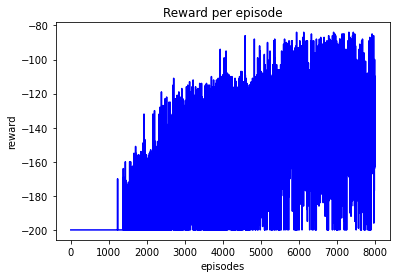

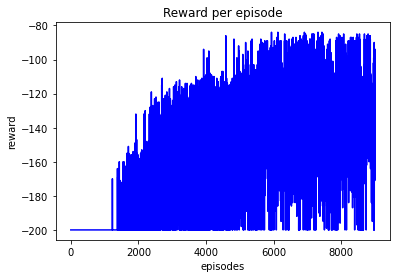

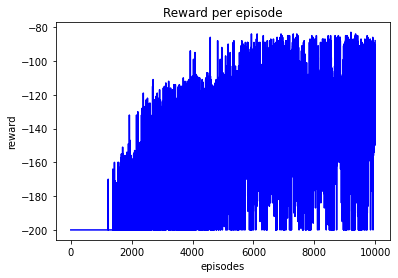

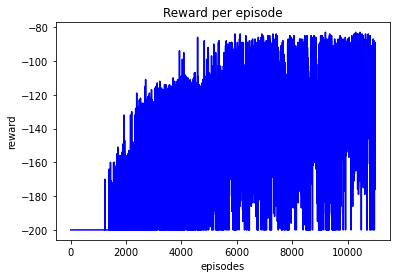

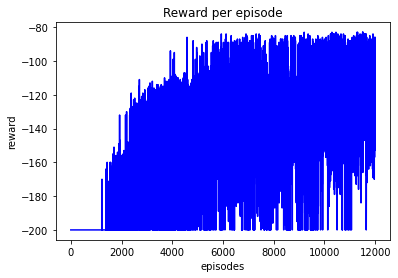

Complete


In [ ]:
BATCH_SIZE = 64 # 64around 32 for cartpole
GAMMA = 0.999
EPS_START = 1
EPS_END = 0.01 # check epsilon value

epsilon = EPS_START
learning_rate = 1e-3


TARGET_UPDATE = 4
max_step = 2000 # 1000
num_episodes = 12000
rewards_per_episode = []

decay_factor = math.pow((EPS_END / EPS_START),(1/num_episodes))
epsilon_per_episode = []
epsilon_per_episode.append(epsilon)


memory = ReplayMemory3(10000) # <10000

n_actions = env3.action_space.n

policy_net = DQN3(env3.observation_space.shape[0],env3.action_space.n).to(device)
target_net = DQN3(env3.observation_space.shape[0],env3.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(),lr=learning_rate)


steps_done = 0


for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env3.reset()
    curr_episode_reward = 0
    
    for t in count():
        # Select and perform an action    
        action = sample_action(policy_net,state)
        
        next_state, reward, done, _ = env3.step(action)
        #reward = np.clip(reward, -1, 1)
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        memory.push([state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state

        # Perform one step of optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          train_step()
        if done:
            break
    
    epsilon = epsilon * decay_factor
    epsilon_per_episode.append(epsilon)
    
    # Every C steps update the target network with the policy network's weights/params
    if i_episode % TARGET_UPDATE == 0:
          #for j,t in zip(target_net.parameters(),policy_net.parameters()):
              #j.data.copy_((0.001*t.data+0.999*j.data))
        target_net.load_state_dict(policy_net.state_dict())

    rewards_per_episode.append(curr_episode_reward)
    if (i_episode+1)%1000==0:
      plt.title("Reward per episode")
      plt.xlabel('episodes')
      plt.ylabel('reward')
      plt.plot(rewards_per_episode, color="blue")
      plt.show()

print('Complete')
#env.render()
# env.close()
# plt.ioff()
# plt.show()

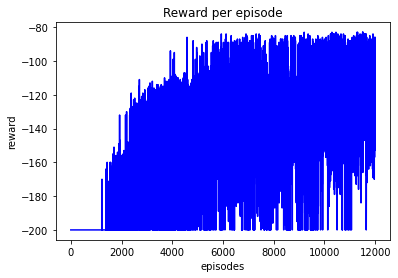

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(rewards_per_episode, color="blue")
plt.show()
plt.savefig("Rewards_per_episode_MountainCar.png",dpi = 1200)

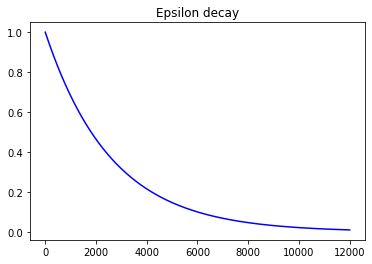

In [ ]:
plt.title("Epsilon decay")
# plt.xlabel('episodes')
# plt.ylabel('reward')
plt.plot(epsilon_per_episode, color="blue")
plt.show()
#plt.savefig("Epsilon_decay_MountainCar.png",dpi = 1200)

Complete


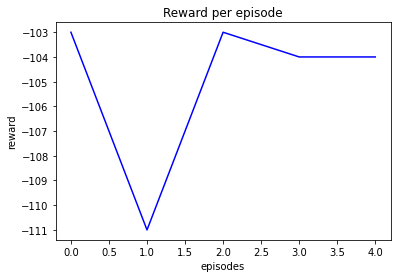

In [ ]:
# plt.title("Epsilon decay")
# # plt.xlabel('episodes')
# # plt.ylabel('reward')
# plt.plot(epsilon_per_episode, color="blue")# Evaluation for 5 episodes
eval_epsiodes = 5
eval_rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    state = env3.reset()
    curr_episode_reward = 0
    epsilon = 0
    
    for t in range(1,2000):
        # Select and perform an action    
        action = sample_action(policy_net,state)
        # observation, reward, done,terminal_state_reached, action_new
        next_state, reward, done, _ = env3.step(action)
        #print(terminal_state_reached)
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        #memory.push([state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          pass
          #train_step()
        if done:
            break
    
    # epsilon = epsilon * decay_factor
    # epsilon_per_episode.append(epsilon)
    
    # Update the target network, copying all weights and biases in DQN
    #if i_episode % TARGET_UPDATE == 0:
        #target_net.load_state_dict(policy_net.state_dict())

    eval_rewards_per_episode.append(curr_episode_reward)
    # if (i_episode+1)%100==0:
      # plt.title("Reward per episode")
      # plt.xlabel('episodes')
      # plt.ylabel('reward')
      # plt.plot(rewards_per_episode, color="blue")
      # plt.show()

print('Complete')

plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(eval_rewards_per_episode, color="blue")
plt.show()
#plt.savefig("CartPole_evaluation.png",dpi=1200)

Complete


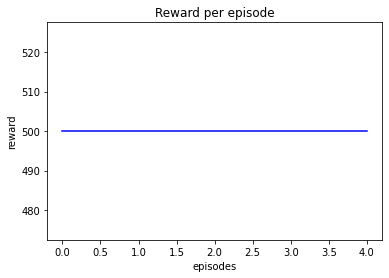

In [ ]:
# plt.title("Epsilon decay")
# # plt.xlabel('episodes')
# # plt.ylabel('reward')
# plt.plot(epsilon_per_episode, color="blue")# Evaluation for 5 episodes
eval_epsiodes = 5
eval_rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    epsilon = 0
    
    for t in range(1,2000):
        # Select and perform an action    
        action = primary_net.sample_action(torch.from_numpy(state).float().to(device),epsilon) # check
        # observation, reward, done,terminal_state_reached, action_new
        next_state, reward, done, _ = env.step(action)
        #print(terminal_state_reached)
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        #memory.push([state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          pass
          #train_step()
        if done:
            break
    
    # epsilon = epsilon * decay_factor
    # epsilon_per_episode.append(epsilon)
    
    # Update the target network, copying all weights and biases in DQN
    #if i_episode % TARGET_UPDATE == 0:
        #target_net.load_state_dict(primary_net.state_dict())

    eval_rewards_per_episode.append(curr_episode_reward)
    # if (i_episode+1)%100==0:
      # plt.title("Reward per episode")
      # plt.xlabel('episodes')
      # plt.ylabel('reward')
      # plt.plot(rewards_per_episode, color="blue")
      # plt.show()

print('Complete')

plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(eval_rewards_per_episode, color="blue")
plt.show()
#plt.savefig("CartPole_evaluation.png",dpi=1200)

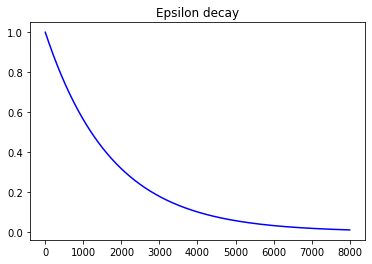

In [ ]:
plt.title("Epsilon decay")

plt.plot(epsilon_per_episode, color="blue")
plt.show()
#plt.savefig("Rewards_per_episode_Cartpole.png",dpi = 1200)

# Double DQN GridWorld

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from gym import spaces


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
a = [[1,2,3,4],1,1,[5,6,7,8]]
b = ["s","a","r","s'"]

dict(zip(b,a))

{'s': [1, 2, 3, 4], 'a': 1, 'r': 1, "s'": [5, 6, 7, 8]}

In [ ]:
from itertools import cycle
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, transition: list):
        """Save a transition"""
        self.memory.append(transition)

    def sample(self, batch_size):
        sample_list = random.sample(self.memory, batch_size)
        dict_keys = ["state","action","reward","next_state","done"] # Convert to dictionary for ease of use and understanding
        
        sample_dicts = list(map(lambda sample: dict(zip(dict_keys,sample)), sample_list))
        #sample_dict = [zip(sample, dict_keys) for sample in sample list]
        
        return sample_dicts

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):
    
    def __init__(self,state_space_len=None,
                 action_space_len=None):
        super(DQN, self).__init__()

        assert state_space_len is not None
        assert action_space_len is not None

        self.fc1 = nn.Linear(state_space_len, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_space_len)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return self.fc3(x)

    def sample_action(self, obs, epsilon):
        if random.random() < epsilon:
            return random.randint(0,3)
        else:
            return self.forward(obs).argmax().item()
    

In [ ]:
class GridEnvironment(gym.Env):
    
    def __init__(self, environment_type, max_timesteps):

        self.environment_type = environment_type
        self.environment_width = 4
        self.environment_height = 4

        self.observation_space = spaces.Discrete(self.environment_width * self.environment_height)
        self.action_space = spaces.Discrete(4)

        self.number_of_agents = 1
        self.agent_pos = np.asarray([0, 0])
        self.goal_pos = np.asarray([3, 3])

        self.candy_pos = np.asarray([0, 3])
        self.diamond_pos = np.asarray([1, 3])
        self.coin_pos = np.asarray([2, 1])

        self.gold_collected = False
        self.candy_collected = False
        self.diamond_collected = False
        self.coin_collected = False


        self.state = np.zeros((4, 4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.candy_pos)] = 0.4
        self.state[tuple(self.diamond_pos)] = 0.3
        self.state[tuple(self.coin_pos)] = 0.2
        
        self.timestep = 0
        self.max_timesteps = max_timesteps
        self.epsilon = 0.9


        
    def reset(self):
        self.timestep = 0
        self.agent_pos = np.asarray([0, 0])
        self.goal_pos = np.asarray([3, 3])
        self.state = np.zeros((4, 4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        observation = self.state.flatten()
        self.gold_collected = False
        self.candy_collected = False
        self.diamond_collected = False
        self.coin_collected = False
        
        return observation
    
    def step(self, action: int):
        rand_num = np.random.random()

        # if self.environment_type != "deterministic":
        #   if np.random.random() > self.epsilon: # exploitation
        #       action = random.choice([0,1,2,3])
         
        if action == 0:
            self.agent_pos[1] += 1 # right
        if action == 1:
          self.agent_pos[0] += 1 # down
        if action == 2:
          self.agent_pos[1] -= 1 # left
        if action == 3:
          self.agent_pos[0] -= 1 # up
        

        self.agent_pos = list(np.clip(self.agent_pos, 0, 3))
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        
        self.state[tuple(self.candy_pos)] = 0.4
        self.state[tuple(self.diamond_pos)] = 0.3
        self.state[tuple(self.coin_pos)] = 0.2


        observation = self.state.flatten()
        
        reward = -1
        terminal_state_reached = False
        if (self.agent_pos == self.goal_pos).all():
            terminal_state_reached = True
            if not self.gold_collected:
              reward = 10
              self.gold_collected = True

        # if (self.agent_pos == self.diamond_pos).all():
        #   if not self.diamond_collected:
        #       reward = 5
        #       self.diamond_collected = True
            
        # if (self.agent_pos == self.candy_pos).all():
        #   if not self.candy_collected:
        #       reward = 3
        #       self.candy_collected = True
            
        # if (self.agent_pos == self.coin_pos).all():
        #   if not self.coin_collected:
        #       reward = 1
        #       self.coin_collected = True
            
        self.timestep += 1
        done = True if (self.timestep > self.max_timesteps) or terminal_state_reached else False
        
        
        info = {}
        action_new = action
        
        return observation, reward, done,terminal_state_reached, action_new


    def render(self):
        plt.figure()
        plt.imshow(self.state)


In [ ]:
from collections import defaultdict
def train_step():
    assert len(memory)> BATCH_SIZE, "Check code! Memory length should be greater than Batch size, only then this function is called"

    batch = memory.sample(BATCH_SIZE)
    #print(batch)
    dd = defaultdict(list)

    # Merge list of dicts into one single dict
    for d in batch:
      for key, value in d.items():
          dd[key].append(value)

    batch = dd

    #print(batch)
    
    state_batch = torch.FloatTensor(batch.get("state")).to(device)
    action_batch = torch.LongTensor(batch.get("action")).unsqueeze(1).to(device)
    reward_batch = torch.FloatTensor(batch.get("reward")).unsqueeze(1).to(device)
    next_state_batch = torch.FloatTensor(batch.get("next_state")).to(device)
    done_batch = torch.FloatTensor(batch.get("done")).unsqueeze(1).to(device)


    #Forward prop target network and calculate target(yi)
    #print(next_state_batch.shape)
    #print(primary_net(next_state_batch))
    Q_primary_max_action_batch = primary_net(next_state_batch).argmax(dim=1).unsqueeze(1).detach()
    
    Q_optimal = reward_batch + GAMMA *  target_net(next_state_batch).gather(1, Q_primary_max_action_batch).detach() * done_batch

    #Q_target_max = target_net(next_state_batch).max(1)[0].unsqueeze(1).detach()

    #target_batch = reward_batch + GAMMA * Q_target_max * done_batch
    #print(state_batch.shape)
    #print(action_batch.shape)
    Q_primary = primary_net(state_batch).gather(1, action_batch)
    
    #Calculate Loss
    criterion = nn.MSELoss() #HuberLoss()#MSELoss() #Check Loss MSE
    loss = criterion(Q_optimal, Q_primary)

    # Backprop gradients
    optimizer.zero_grad()
    loss.backward()
    for param in primary_net.parameters():
        param.grad.data.clamp_(-1, 1)

    optimizer.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Complete


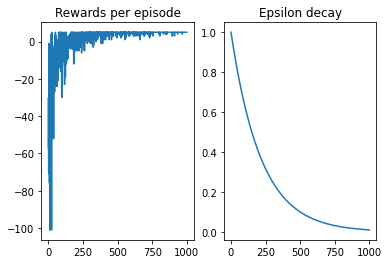

In [ ]:
from gym.spaces.discrete import Discrete # Scale reward [-1,1]
BATCH_SIZE = 32 #200 # around 32 for cartpole
GAMMA = 0.9 #0.999
EPS_START = 1
EPS_END = 0.01

epsilon = EPS_START
learning_rate = 1e-3


TARGET_UPDATE = 10
max_step = 100 #2000
num_episodes = 1000
rewards_per_episode = []

decay_factor = math.pow((EPS_END / EPS_START),(1/num_episodes))
epsilon_per_episode = []
epsilon_per_episode.append(epsilon)

env = GridEnvironment("deterministic",max_timesteps=max_step)

memory = ReplayMemory(5000) # <10000
Discrete
n_actions = env.action_space.n
#print(env.observation_space)
primary_net = DQN(env.observation_space.n,env.action_space.n).to(device)
target_net = DQN(env.observation_space.n,env.action_space.n).to(device)
target_net.load_state_dict(primary_net.state_dict())
target_net.eval()

optimizer = optim.Adam(primary_net.parameters(),lr=learning_rate)


steps_done = 0


for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    
    for t in count():
        # Select and perform an action    
        action = primary_net.sample_action(torch.from_numpy(state).float().to(device),epsilon) # check
        # observation, reward, done,terminal_state_reached, action_new
        next_state, reward, done, terminal_state_reached,_ = env.step(action)
        #print(terminal_state_reached)
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        memory.push([state, action,reward,next_state,not terminal_state_reached])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          train_step()
        if done:
            break
    
    epsilon = epsilon * decay_factor
    epsilon_per_episode.append(epsilon)
    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(primary_net.state_dict())

    rewards_per_episode.append(curr_episode_reward)
    # if (i_episode+1)%100==0:
      # plt.title("Reward per episode")
      # plt.xlabel('episodes')
      # plt.ylabel('reward')
      # plt.plot(rewards_per_episode, color="blue")
      # plt.show()

print('Complete')
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Rewards per episode')
ax[0].plot(rewards_per_episode)

ax[1].set_title('Epsilon decay')
ax[1].plot(epsilon_per_episode)

plt.savefig("Assignment2_GridWorld.png",dpi=1200)
#env.render()
# env.close()
# plt.ioff()
# plt.show()

Complete


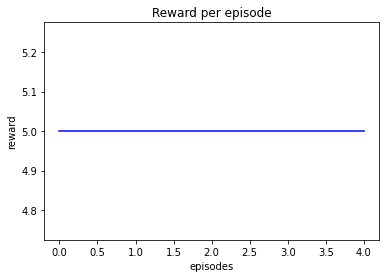

<Figure size 432x288 with 0 Axes>

In [ ]:
# Evaluation for 5 episodes
eval_epsiodes = 5
rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    epsilon = 0
    
    for t in count():
        # Select and perform an action    
        action = primary_net.sample_action(torch.from_numpy(state).float().to(device),epsilon) # check
        # observation, reward, done,terminal_state_reached, action_new
        next_state, reward, done, terminal_state_reached,_ = env.step(action)
        #print(terminal_state_reached)
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        #memory.push([state, action,reward,next_state,not terminal_state_reached])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        # if len(memory)>BATCH_SIZE:
        #   pass
          #train_step()
        if done:
            break
    
    # epsilon = epsilon * decay_factor
    # epsilon_per_episode.append(epsilon)
    
    # Update the target network, copying all weights and biases in DQN
    # if i_episode % TARGET_UPDATE == 0:
    #     target_net.load_state_dict(policy_net.state_dict())

    rewards_per_episode.append(curr_episode_reward)
    # if (i_episode+1)%100==0:
      # plt.title("Reward per episode")
      # plt.xlabel('episodes')
      # plt.ylabel('reward')
      # plt.plot(rewards_per_episode, color="blue")
      # plt.show()

print('Complete')
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(rewards_per_episode, color="blue")
plt.show()
plt.savefig("Gridworld_evaluation.png",dpi=1200)


# Double DQN CartPole

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
%%bash
pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v1')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [ ]:
from itertools import cycle
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, transition: list):
        self.memory.append(transition)

    def sample(self, batch_size):
        sample_list = random.sample(self.memory, batch_size)
        dict_keys = ["state","action","reward","next_state","done"] # Convert to dictionary for ease of use and understanding
        
        sample_dicts = list(map(lambda sample: dict(zip(dict_keys,sample)), sample_list))
        #sample_dict = [zip(sample, dict_keys) for sample in sample list]
        
        return sample_dicts

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):
    
    def __init__(self,state_space_len=None,
                 action_space_len=None):
        super(DQN, self).__init__()

        assert state_space_len is not None
        assert action_space_len is not None

        self.fc1 = nn.Linear(state_space_len, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_space_len)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return self.fc3(x)

    def sample_action(self, obs, epsilon):
        if random.random() < epsilon:
            return random.randint(0,1)
        else:
            return self.forward(obs).argmax().item()
    

In [ ]:
a = [{'a':1},{'b':2},{'c':1},{'d':2},{'b':3}]
from collections import defaultdict
dd = defaultdict(list)

for d in a: # you can list as many input dicts as you want here
    for key, value in d.items():
        dd[key].append(value)
    
print(dd)


defaultdict(<class 'list'>, {'a': [1], 'b': [2, 3], 'c': [1], 'd': [2]})


In [ ]:
from collections import defaultdict
def train_step():
    assert len(memory)> BATCH_SIZE, "Check code! Memory length should be greater than Batch size, only then this function is called"

    batch = memory.sample(BATCH_SIZE)
    #print(batch)
    dd = defaultdict(list)

    # Merge list of dicts into one single dict
    for d in batch:
      for key, value in d.items():
          dd[key].append(value)

    batch = dd

    #print(batch)
    
    state_batch = torch.FloatTensor(np.array(batch.get("state"))).to(device)
    action_batch = torch.LongTensor(np.array(batch.get("action"))).unsqueeze(1).to(device)
    reward_batch = torch.FloatTensor(np.array(batch.get("reward"))).unsqueeze(1).to(device)
    next_state_batch = torch.FloatTensor(np.array(batch.get("next_state"))).to(device)
    done_batch = torch.FloatTensor(np.array(batch.get("done"))).unsqueeze(1).to(device)


    #Forward prop target network and calculate target(yi)
    
    Q_primary_max_action_batch = primary_net(next_state_batch).argmax(dim=1).unsqueeze(1).detach()
    #print(Q_primary_max_action_batch.shape)
    Q_optimal = reward_batch + GAMMA *  target_net(next_state_batch).gather(1, Q_primary_max_action_batch).detach() * done_batch

    #Q_target_max = target_net(next_state_batch).max(1)[0].unsqueeze(1).detach()

    #target_batch = reward_batch + GAMMA * Q_target_max * done_batch
    #print(state_batch.shape)
    #print(action_batch.shape)
    Q_primary = primary_net(state_batch).gather(1, action_batch)
    
    #Calculate Loss
    criterion = nn.MSELoss() #HuberLoss()#MSELoss() #Check Loss MSE
    loss = criterion(Q_optimal, Q_primary)

    # Backprop gradients
    optimizer.zero_grad()
    loss.backward()
    # for param in primary_net.parameters():
    #     param.grad.data.clamp_(-1, 1)

    optimizer.step()

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1


In [ ]:
import gym
from gym import logger as gymlogger
#from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = gym.wrappers.RecordVideo(env, './video')
  return env

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

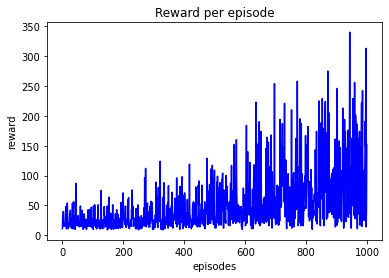

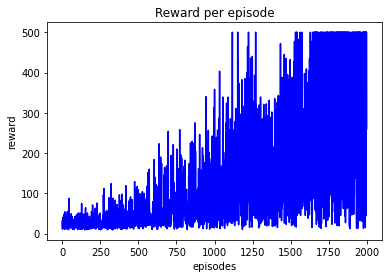

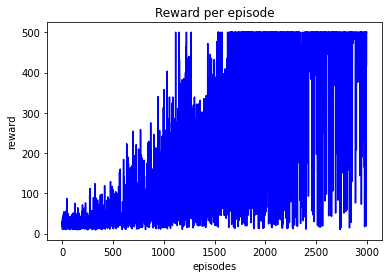

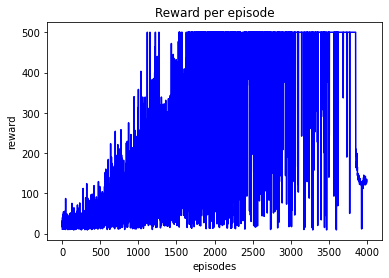

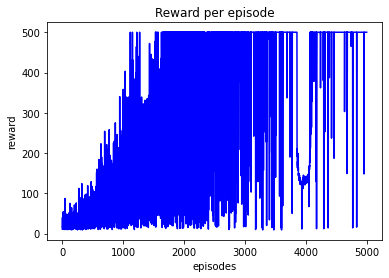

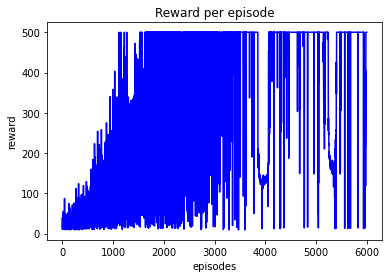

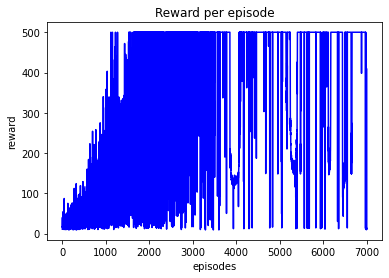

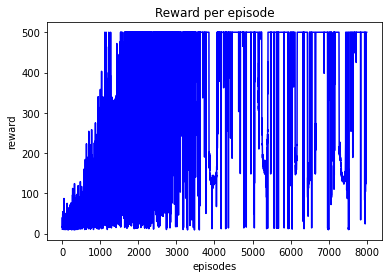

Complete


In [ ]:
BATCH_SIZE = 32 # 64around 32 for cartpole
GAMMA = 0.999
EPS_START = 1
EPS_END = 0.01 # check epsilon value

epsilon = EPS_START
learning_rate = 1e-4


TARGET_UPDATE = 4
max_step = 2000 # 1000
num_episodes = 8000
rewards_per_episode = []

decay_factor = math.pow((EPS_END / EPS_START),(1/num_episodes))
epsilon_per_episode = []
epsilon_per_episode.append(epsilon)

#env = wrap_env(env)
memory = ReplayMemory(5000) # <10000

n_actions = env.action_space.n

primary_net = DQN(env.observation_space.shape[0],env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0],env.action_space.n).to(device)
target_net.load_state_dict(primary_net.state_dict())
target_net.eval()

optimizer = optim.Adam(primary_net.parameters(),lr=learning_rate)


steps_done = 0


for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    
    for t in range(max_step):
        # Select and perform an action
        #env.render()
        # screen = env.render(mode='rgb_array')

        # plt.imshow(screen)
        # ipythondisplay.clear_output(wait=True)
        # ipythondisplay.display(plt.gcf())    
        action = primary_net.sample_action(torch.from_numpy(state).float().to(device),epsilon)
        
        next_state, reward, done, _ = env.step(action)
        #reward = np.clip(reward, -1, 1)
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        memory.push([state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state

        # Perform one step of optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          train_step()
        if done:
            break
    
    epsilon = epsilon * decay_factor
    epsilon_per_episode.append(epsilon)
    
    # Every C steps update the target network with the policy network's weights/params
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(primary_net.state_dict())

    rewards_per_episode.append(curr_episode_reward)
    if (i_episode+1)%1000==0:
      plt.title("Reward per episode")
      plt.xlabel('episodes')
      plt.ylabel('reward')
      plt.plot(rewards_per_episode, color="blue")
      plt.show()

print('Complete')
#env.render()
# env.close()
# plt.ioff()
# plt.show()

# Double DQN MountainCar

In [ ]:
%matplotlib inline

In [ ]:
%%bash
pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('MountainCar-v0')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


cuda


In [ ]:
from itertools import cycle
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, transition: list):
        """Save a transition"""
        self.memory.append(transition)

    def sample(self, batch_size):
        sample_list = random.sample(self.memory, batch_size)
        dict_keys = ["state","action","reward","next_state","done"] # Convert to dictionary for ease of use and understanding
        
        sample_dicts = list(map(lambda sample: dict(zip(dict_keys,sample)), sample_list))
        #sample_dict = [zip(sample, dict_keys) for sample in sample list]
        
        return sample_dicts

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):
    
    def __init__(self,state_space_len=None,
                 action_space_len=None):
        super(DQN, self).__init__()

        assert state_space_len is not None
        assert action_space_len is not None

        self.fc1 = nn.Linear(state_space_len, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, action_space_len)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return self.fc3(x)

    def sample_action(self, obs, epsilon):
        if random.random() < epsilon:
            return random.randint(0,2)
        else:
            return self.forward(obs).argmax().item()
    

In [ ]:
from collections import defaultdict
def train_step():
    assert len(memory)> BATCH_SIZE, "Check code! Memory length should be greater than Batch size, only then this function is called"

    batch = memory.sample(BATCH_SIZE)
    #print(batch)
    dd = defaultdict(list)

    # Merge list of dicts into one single dict
    for d in batch:
      for key, value in d.items():
          dd[key].append(value)

    batch = dd

    #print(batch)
    
    state_batch = torch.FloatTensor(np.array(batch.get("state"))).to(device)
    action_batch = torch.LongTensor(np.array(batch.get("action"))).unsqueeze(1).to(device)
    reward_batch = torch.FloatTensor(np.array(batch.get("reward"))).unsqueeze(1).to(device)
    next_state_batch = torch.FloatTensor(np.array(batch.get("next_state"))).to(device)
    done_batch = torch.FloatTensor(np.array(batch.get("done"))).unsqueeze(1).to(device)


    #Forward prop target network and calculate target(yi)
    
    Q_primary_max_action_batch = primary_net(next_state_batch).argmax(dim=1).unsqueeze(1).detach()
    #print(Q_primary_max_action_batch.shape)
    Q_optimal = reward_batch + GAMMA *  target_net(next_state_batch).gather(1, Q_primary_max_action_batch).detach() * done_batch

    #Q_target_max = target_net(next_state_batch).max(1)[0].unsqueeze(1).detach()

    #target_batch = reward_batch + GAMMA * Q_target_max * done_batch
    #print(state_batch.shape)
    #print(action_batch.shape)
    Q_primary = primary_net(state_batch).gather(1, action_batch)
    
    #Calculate Loss
    criterion = nn.MSELoss() #HuberLoss()#MSELoss() #Check Loss MSE
    loss = criterion(Q_optimal, Q_primary)

    # Backprop gradients
    optimizer.zero_grad()
    loss.backward()
    # for param in primary_net.parameters():
    #     param.grad.data.clamp_(-1, 1)

    optimizer.step()

    return loss.item()

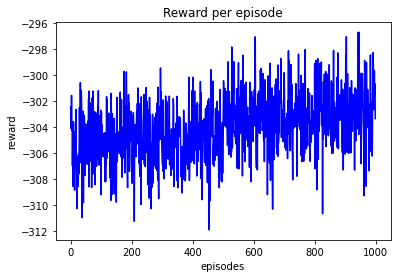

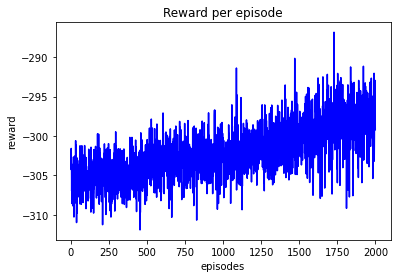

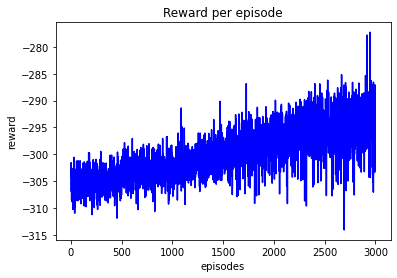

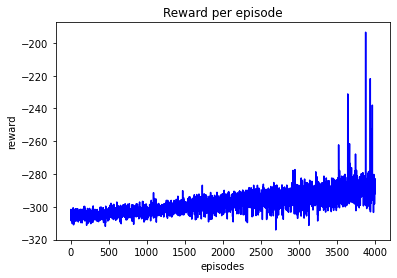

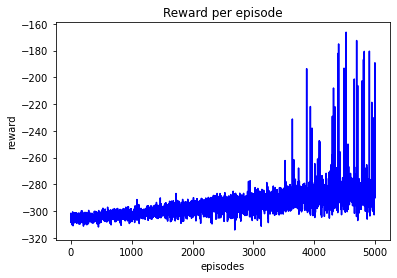

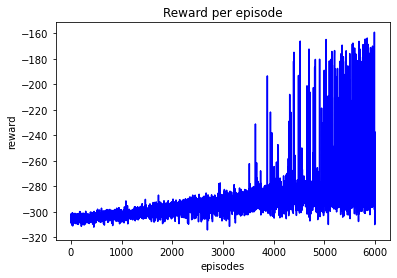

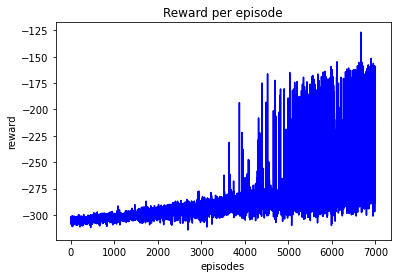

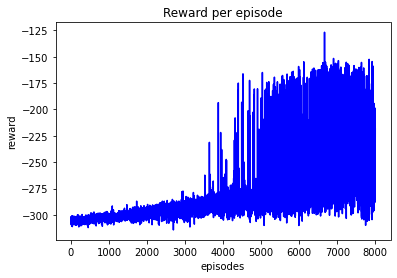

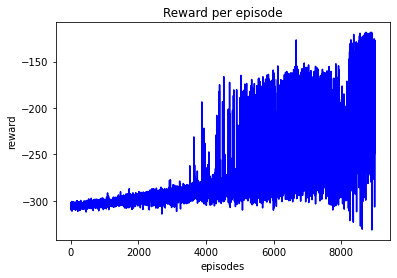

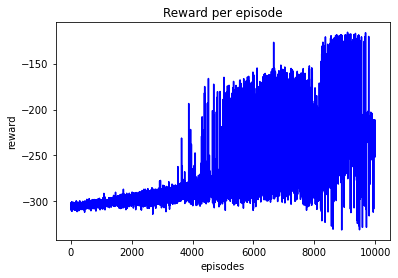

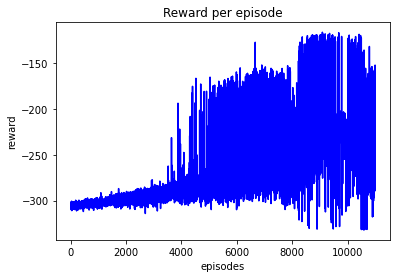

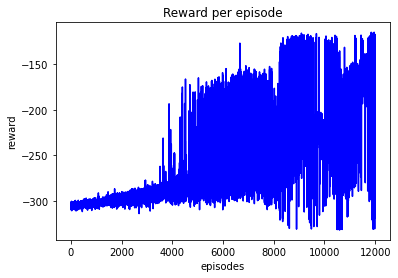

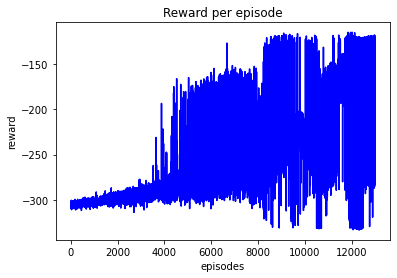

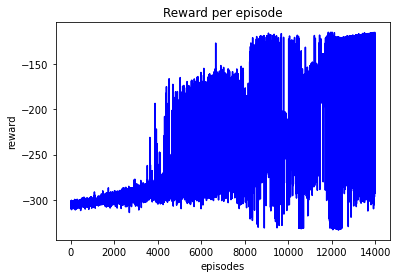

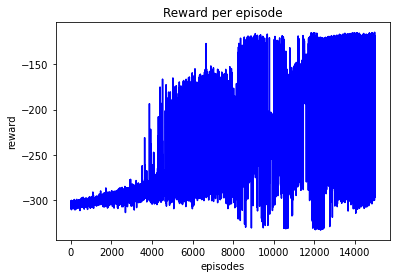

Complete


In [ ]:
BATCH_SIZE = 32 #32 # around 32 for cartpole
GAMMA = 1
EPS_START = 1
EPS_END = 0.01

epsilon = EPS_START
learning_rate = 1e-3#1e-3


TARGET_UPDATE = 100
max_step = 2000
num_episodes = 15000
rewards_per_episode = []


decay_factor = math.pow((EPS_END / EPS_START),(1/num_episodes))
epsilon_per_episode = []
epsilon_per_episode.append(epsilon)


memory = ReplayMemory(100000) # <10000

n_actions = env.action_space.n

primary_net = DQN(env.observation_space.shape[0],env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0],env.action_space.n).to(device)
target_net.load_state_dict(primary_net.state_dict())
target_net.eval()

optimizer = optim.Adam(primary_net.parameters(),lr=learning_rate)


steps_done = 0
loss_per_episode = []


for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    episode_loss = 0
    t = 0

    for t in count():
        # Select and perform an action    
        action = primary_net.sample_action(torch.from_numpy(state).float().to(device),epsilon)
        
        next_state, reward, done, _ = env.step(action)

        # reward = 100*((np.sin(3 * next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) - (np.sin(3 * state[0]) * 0.0025 + 0.5 * state[1] * state[1])) 
        # if next_state[0] >= 0.5:
        #     reward += 1
        
        #curr_episode_reward += reward
        
        reward+= next_state[0]
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        memory.push([state, action,reward/100.0,next_state,not done])

        # Move to the next state
        state = next_state

        # Perform one step of optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          loss = train_step()
          episode_loss+=loss
        if done:
            break

    loss_per_episode.append(episode_loss/t)
    epsilon = epsilon * decay_factor
    epsilon_per_episode.append(epsilon)
    
    # Every C steps update the target network with the policy network's weights/params
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(primary_net.state_dict())

    rewards_per_episode.append(curr_episode_reward)
    if (i_episode+1)%1000==0:
      plt.title("Reward per episode")
      plt.xlabel('episodes')
      plt.ylabel('reward')
      plt.plot(rewards_per_episode, color="blue")
      plt.show()

print('Complete')
#env.render()
# env.close()
# plt.ioff()
# plt.show()

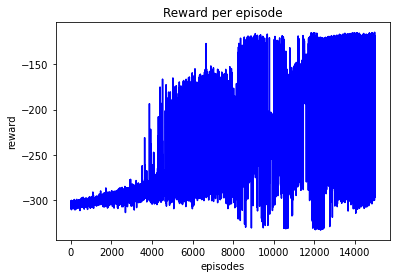

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(rewards_per_episode, color="blue")
plt.show()
plt.savefig("Rewards_per_episode_MountainCar.png",dpi = 1200)

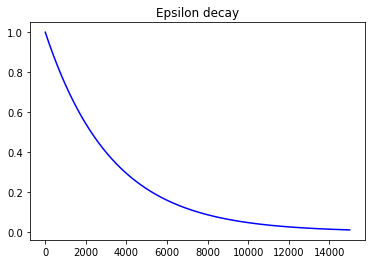

In [ ]:
plt.title("Epsilon decay")
# plt.xlabel('episodes')
# plt.ylabel('reward')
plt.plot(epsilon_per_episode, color="blue")
plt.show()
#plt.savefig("Epsilon_decay_MountainCar.png",dpi = 1200)

Complete


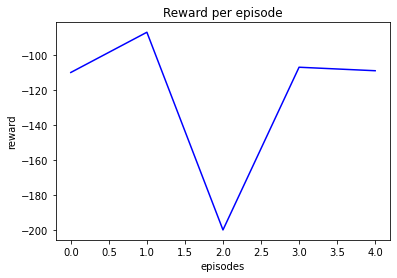

In [ ]:
# plt.title("Epsilon decay")
# # plt.xlabel('episodes')
# # plt.ylabel('reward')
# plt.plot(epsilon_per_episode, color="blue")# Evaluation for 5 episodes
eval_epsiodes = 5
eval_rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    epsilon = 0
    
    for t in range(1,2000):
        # Select and perform an action    
        action = primary_net.sample_action(torch.from_numpy(state).float().to(device),epsilon) # check
        # observation, reward, done,terminal_state_reached, action_new
        next_state, reward, done, _ = env.step(action)
        #print(terminal_state_reached)
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        #memory.push([state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          pass
          #train_step()
        if done:
            break
    
    # epsilon = epsilon * decay_factor
    # epsilon_per_episode.append(epsilon)
    
    # Update the target network, copying all weights and biases in DQN
    #if i_episode % TARGET_UPDATE == 0:
        #target_net.load_state_dict(policy_net.state_dict())

    eval_rewards_per_episode.append(curr_episode_reward)
    # if (i_episode+1)%100==0:
      # plt.title("Reward per episode")
      # plt.xlabel('episodes')
      # plt.ylabel('reward')
      # plt.plot(rewards_per_episode, color="blue")
      # plt.show()

print('Complete')

plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(eval_rewards_per_episode, color="blue")
plt.show()
#plt.savefig("CartPole_evaluation.png",dpi=1200)